# Validate Turbo and Convolutional Codes

Test convolutional and Turbo codes against multiple baselines and sweep over cosntraint length, to verify that correct polynomials are taken.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time # for throughput measurements

2024-11-27 11:20:55.487027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 11:20:55.487078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 11:20:55.488187: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 11:20:55.494446: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 2
Only GPU number 0 used.


2024-11-27 11:20:56.850198: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-27 11:20:56.852118: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-27 11:20:56.896056: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
import sys
sys.path.append('../../..')
import sionna
%reload_ext autoreload
%autoreload 2
import importlib
importlib.reload(sionna)

# Load the required Sionna components
from sionna.phy.mapping import Constellation, Mapper, Demapper
from sionna.phy.fec.polar import PolarEncoder, Polar5GEncoder, PolarSCLDecoder, Polar5GDecoder, PolarSCDecoder
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.fec.polar.utils import generate_5g_ranking, generate_rm_code
from sionna.phy.fec.conv import ConvEncoder, ViterbiDecoder, BCJRDecoder
from sionna.phy.fec.turbo import TurboEncoder, TurboDecoder
from sionna.phy.utils import BinarySource, ebnodb2no
from sionna.phy.utils.metrics import  count_block_errors
from sionna.phy.channel import AWGN
from sionna.phy.utils.plotting import PlotBER
from sionna.phy.fec.utils import GaussianPriorSource, llr2mi

In [4]:
class System_Model(tf.keras.Model):
    """System model for channel coding BER simulations.

    This model allows to simulate BERs over an AWGN channel with
    QAM modulation. Arbitrary FEC encoder/decoder layers can be used to
    initialize the model.

    Parameters
    ----------
        k: int
            number of information bits per codeword.

        n: int
            codeword length.

        num_bits_per_symbol: int
            number of bits per QAM symbol.

        encoder: Keras layer
            A Keras layer that encodes information bit tensors.

        decoder: Keras layer
            A Keras layer that decodes llr tensors.

        demapping_method: str
            A string denoting the demapping method. Can be either "app" or "maxlog".

        sim_esno: bool
            A boolean defaults to False. If true, no rate-adjustment is done for the SNR calculation.

    Input
    -----
        batch_size: int or tf.int
            The batch_size used for the simulation.

        ebno_db: float or tf.float
            A float defining the simulation SNR.

    Output
    ------
        (u, u_hat):
            Tuple:

        u: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the transmitted information bits.

        u_hat: tf.float32
            A tensor of shape `[batch_size, k] of 0s and 1s containing the estimated information bits.
    """
    def __init__(self,
                 k,
                 n,
                 num_bits_per_symbol,
                 encoder,
                 decoder,
                 demapping_method="app",
                 sim_esno=False):

        super().__init__()

        # store values internally
        self.k = k
        self.n = n
        self.sim_esno = sim_esno # disable rate-adjustment for SNR calc

        # number of bit per QAM symbol
        self.num_bits_per_symbol = num_bits_per_symbol

        # init components
        self.source = BinarySource()

        # initialize mapper and demapper for constellation object
        self.constellation = Constellation("qam",
                                num_bits_per_symbol=self.num_bits_per_symbol)
        self.mapper = Mapper(constellation=self.constellation)
        self.demapper = Demapper(demapping_method,
                                 constellation=self.constellation)

        # the channel can be replaced by more sophisticated models
        self.channel = AWGN()

        # FEC encoder / decoder
        self.encoder = encoder
        self.decoder = decoder

    @tf.function(jit_compile=True) # enable graph mode for increased throughputs
    def call(self, batch_size, ebno_db):

        u = self.source([batch_size, self.k]) # generate random data
        c = self.encoder(u) # explicitly encode

        # calculate noise variance
        if self.sim_esno:
            no = ebnodb2no(ebno_db,
                       num_bits_per_symbol=1,
                       coderate=1)
        else:
            no = ebnodb2no(ebno_db,
                           num_bits_per_symbol=self.num_bits_per_symbol,
                           coderate=self.k/self.n)

        x = self.mapper(c) # map c to symbols x

        y = self.channel(x, no) # transmit over AWGN channel

        llr_ch = self.demapper(y, no) # demap y to LLRs

        u_hat = self.decoder(llr_ch) # run FEC decoder (incl. rate-recovery)
        return u, u_hat

## Test against APP

In [5]:
# code parameters
k = 512 # number of information bits per codeword
n = 1548 # desired codeword length
num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(0, 2.6, 0.2) # sim SNR range

codes_under_test = []
#Turbo. codes
enc = TurboEncoder(rate=1/3, constraint_length=4, terminate=True)
dec = TurboDecoder(encoder=enc, num_iter=3)
name = "Turbo - iter 3"
codes_under_test.append([enc, dec, name])

enc = TurboEncoder(rate=1/3, constraint_length=4, terminate=True)
dec = TurboDecoder(encoder=enc, num_iter=6)
name = "Turbo - iter 6"
codes_under_test.append([enc, dec, name])

ber_plot1 = PlotBER(f"BER/BLER Performance (k={k}, n={n})")

# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\n Running: " + code[2])

    # generate a new model with the given encoder/decoder
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1],
                         sim_esno=False)

    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    ber_plot1.simulate(model, # the function have defined previously
                     ebno_dbs=ebno_db, # SNR to simulate
                     legend=code[2], # legend string for plotting
                     max_mc_iter=100, # run 100 Monte Carlo runs per SNR point
                     num_target_bit_errors=1000, # continue with next SNR point after 1000 bit errors
                     batch_size=10000, # batch-size per Monte Carlo run
                     soft_estimates=False, # the model returns hard-estimates
                     early_stop=True, # stop simulation if no error has been detected at current SNR point
                     show_fig=False, # we show the figure after all results are simulated
                     add_bler=True, # in case BLER is also interresting
                     forward_keyboard_interrupt=False); # should be True in a loop

# APP reference

snr = [0, 0.5, 1, 1.5, 2, 2.5]
ber = [9e-2, 3e-2, 3e-3, 9e-5, 2e-6, 8e-8]
ber_plot1.add(snr, ber, is_bler=False,legend="APP iter 3")


snr = [0, 0.5, 1, 1.5, 1.75]
ber = [8e-2, 1.5e-2, 5e-4, 1.5e-5, 1.5e-6]
ber_plot1.add(snr, ber, is_bler=False,legend="APP iter 6")


2024-11-27 11:20:57.815693: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-27 11:20:57.817561: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-27 11:20:57.819174: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-


 Running: Turbo - iter 3
<dtype: 'float32'>


2024-11-27 11:21:01.020026: I external/local_xla/xla/service/service.cc:168] XLA service 0x5d4e7f551e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-27 11:21:01.020071: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-27 11:21:01.077007: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_less_equal/Assert/Assert
2024-11-27 11:21:01.077093: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal/Assert/Assert
2024-11-27 11:21:01.077205: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal_1/Assert/Assert
2024-11-27 11:21:01.077276: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_less_equal_1/Assert/Assert
2024-11-27 11:21:01.077326: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignori

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 9.0198e-02 | 9.6290e-01 |      461815 |     5120000 |         9629 |       10000 |        28.2 |reached target bit errors
      0.2 | 6.4656e-02 | 8.8510e-01 |      331041 |     5120000 |         8851 |       10000 |         0.2 |reached target bit errors
      0.4 | 3.8352e-02 | 7.2510e-01 |      196362 |     5120000 |         7251 |       10000 |         0.2 |reached target bit errors
      0.6 | 2.0524e-02 | 5.1140e-01 |      105084 |     5120000 |         5114 |       10000 |         0.2 |reached target bit errors
      0.8 | 8.8408e-03 | 3.0420e-01 |       45265 |     5120000 |         3042 |       10000 |         0.2 |reached target bit errors
      1.0 | 3.1668e-03 | 1.3530e-01 |       16214 |     5120000 |         1

2024-11-27 11:22:36.565350: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_less_equal/Assert/Assert
2024-11-27 11:22:36.565440: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal/Assert/Assert
2024-11-27 11:22:36.565572: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal_1/Assert/Assert
2024-11-27 11:22:36.565815: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_less_equal_1/Assert/Assert
2024-11-27 11:22:36.565863: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal_2/Assert/Assert
2024-11-27 11:22:36.626589: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_equal_1/Assert/Assert
2024-11-27 11:22:40.841330: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 4s:

  %pad.6 = f32[5

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 7.4404e-02 | 7.3040e-01 |      380951 |     5120000 |         7304 |       10000 |        26.1 |reached target bit errors
      0.2 | 4.4228e-02 | 5.0530e-01 |      226445 |     5120000 |         5053 |       10000 |         0.4 |reached target bit errors
      0.4 | 2.2294e-02 | 2.9170e-01 |      114146 |     5120000 |         2917 |       10000 |         0.4 |reached target bit errors
      0.6 | 8.4553e-03 | 1.2770e-01 |       43291 |     5120000 |         1277 |       10000 |         0.4 |reached target bit errors
      0.8 | 2.7717e-03 | 4.8200e-02 |       14191 |     5120000 |          482 |       10000 |         0.4 |reached target bit errors
      1.0 | 6.8105e-04 | 1.3200e-02 |        3487 |     5120000 |          

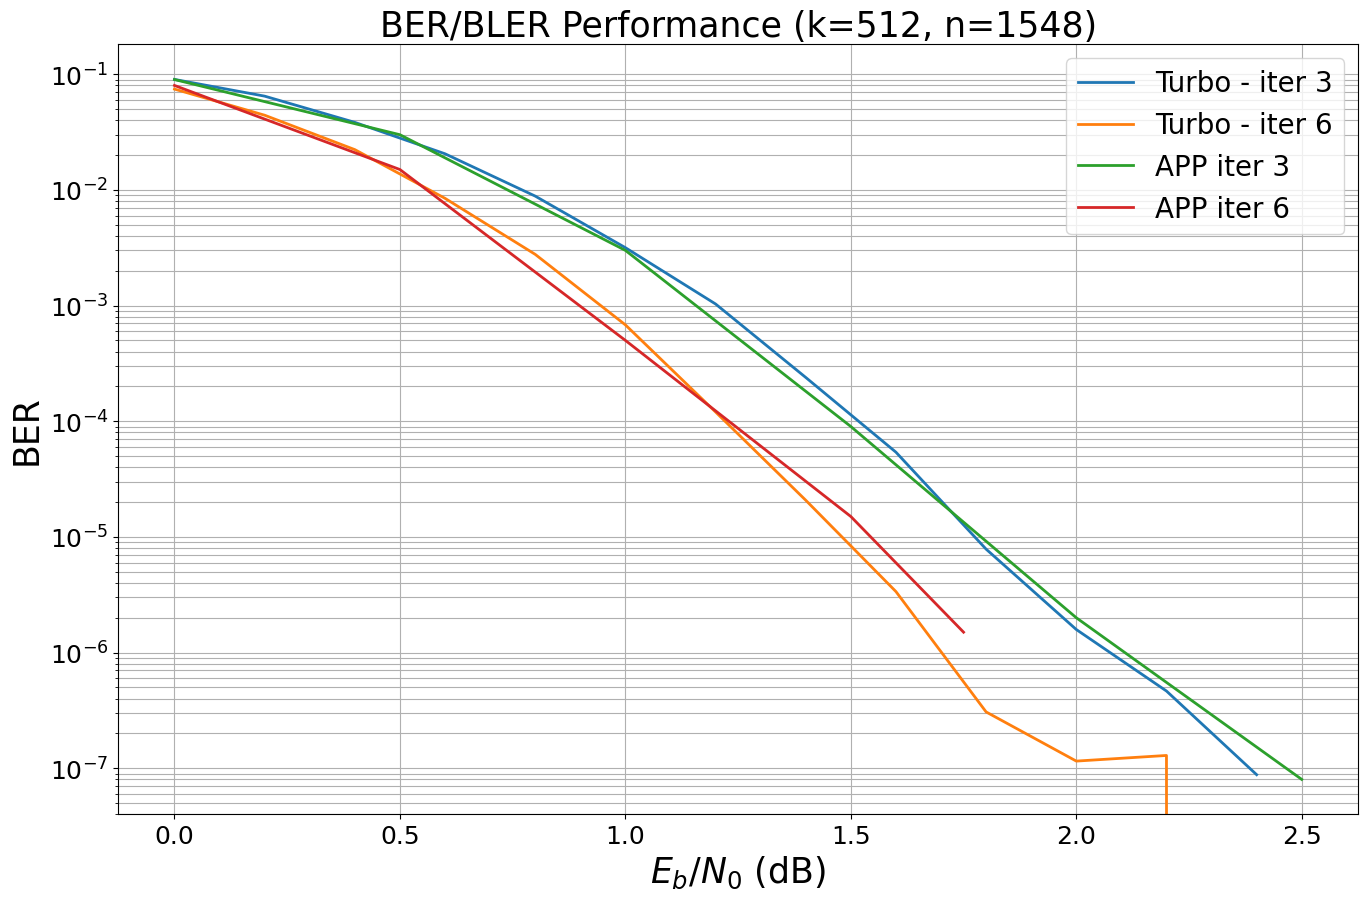

In [6]:
# and show the figure
ber_plot1(show_bler=False)

## Test Against Aff3ct

We test against the aff3ct BER performance.

### Aff3ct k=2048/n=4108

In [7]:
# code parameters
k = 2048 # number of information bits per codeword
n = 4104 # desired codeword length
num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(0, 2, 0.2) # sim SNR range

codes_under_test = []
#Turbo. codes
enc = TurboEncoder(rate=1/2, constraint_length=4, terminate=True)
dec = TurboDecoder(encoder=enc, num_iter=8)
name = "Turbo - constraint_length " + str(enc.constraint_length)
codes_under_test.append([enc, dec, name])

ber_plot2 = PlotBER(f"BER/BLER Performance (k={k}, n={n})")

# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\n Running: " + code[2])

    # generate a new model with the given encoder/decoder
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1],
                         sim_esno=False)

    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    ber_plot2.simulate(model, # the function have defined previously
                     ebno_dbs=ebno_db, # SNR to simulate
                     legend=code[2], # legend string for plotting
                     max_mc_iter=100, # run 100 Monte Carlo runs per SNR point
                     num_target_bit_errors=1000, # continue with next SNR point after 1000 bit errors
                     batch_size=10000, # batch-size per Monte Carlo run
                     soft_estimates=False, # the model returns hard-estimates
                     early_stop=True, # stop simulation if no error has been detected at current SNR point
                     show_fig=False, # we show the figure after all results are simulated
                     add_bler=True, # in case BLER is also interresting
                     forward_keyboard_interrupt=False); # should be True in a loop

#Aff3ct results
#https://aff3ct.github.io/comparator.html?curve0=773c4e0&xaxis=Eb%2FN0&yaxes=BER%2CFER&xrange=-0.026776519052523172,1.973223480947477&yrange=-9.17124842407813,0.1896539704466922

snr = [0, 0.5, 1, 1.5, 2]
ber = [1.67e-01, 1.26e-01, 1.81e-02, 1.43e-05, 3.76e-09]
bler = [1., 1., 3.16e-01, 6.88e-04, 2.21e-06]

ber_plot2.add(snr, ber, is_bler=False,legend="Aff3ct")
ber_plot2.add(snr, bler, is_bler=True,legend="Aff3ct")




 Running: Turbo - constraint_length 4
<dtype: 'float32'>


2024-11-27 11:26:09.031969: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_less_equal/Assert/Assert
2024-11-27 11:26:09.032060: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal/Assert/Assert
2024-11-27 11:26:09.032202: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal_1/Assert/Assert
2024-11-27 11:26:09.032253: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_less_equal_1/Assert/Assert
2024-11-27 11:26:09.032302: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal_2/Assert/Assert
2024-11-27 11:26:09.112665: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_equal_1/Assert/Assert


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.2526e-01 | 1.0000e+00 |     2565270 |    20480000 |        10000 |       10000 |        12.5 |reached target bit errors
      0.2 | 1.1008e-01 | 9.9930e-01 |     2254478 |    20480000 |         9993 |       10000 |         2.1 |reached target bit errors
      0.4 | 8.7587e-02 | 9.8080e-01 |     1793782 |    20480000 |         9808 |       10000 |         2.1 |reached target bit errors
      0.6 | 5.3711e-02 | 8.2840e-01 |     1099998 |    20480000 |         8284 |       10000 |         2.1 |reached target bit errors
      0.8 | 2.0032e-02 | 4.3870e-01 |      410250 |    20480000 |         4387 |       10000 |         2.1 |reached target bit errors
      1.0 | 3.4313e-03 | 1.0410e-01 |       70273 |    20480000 |         1

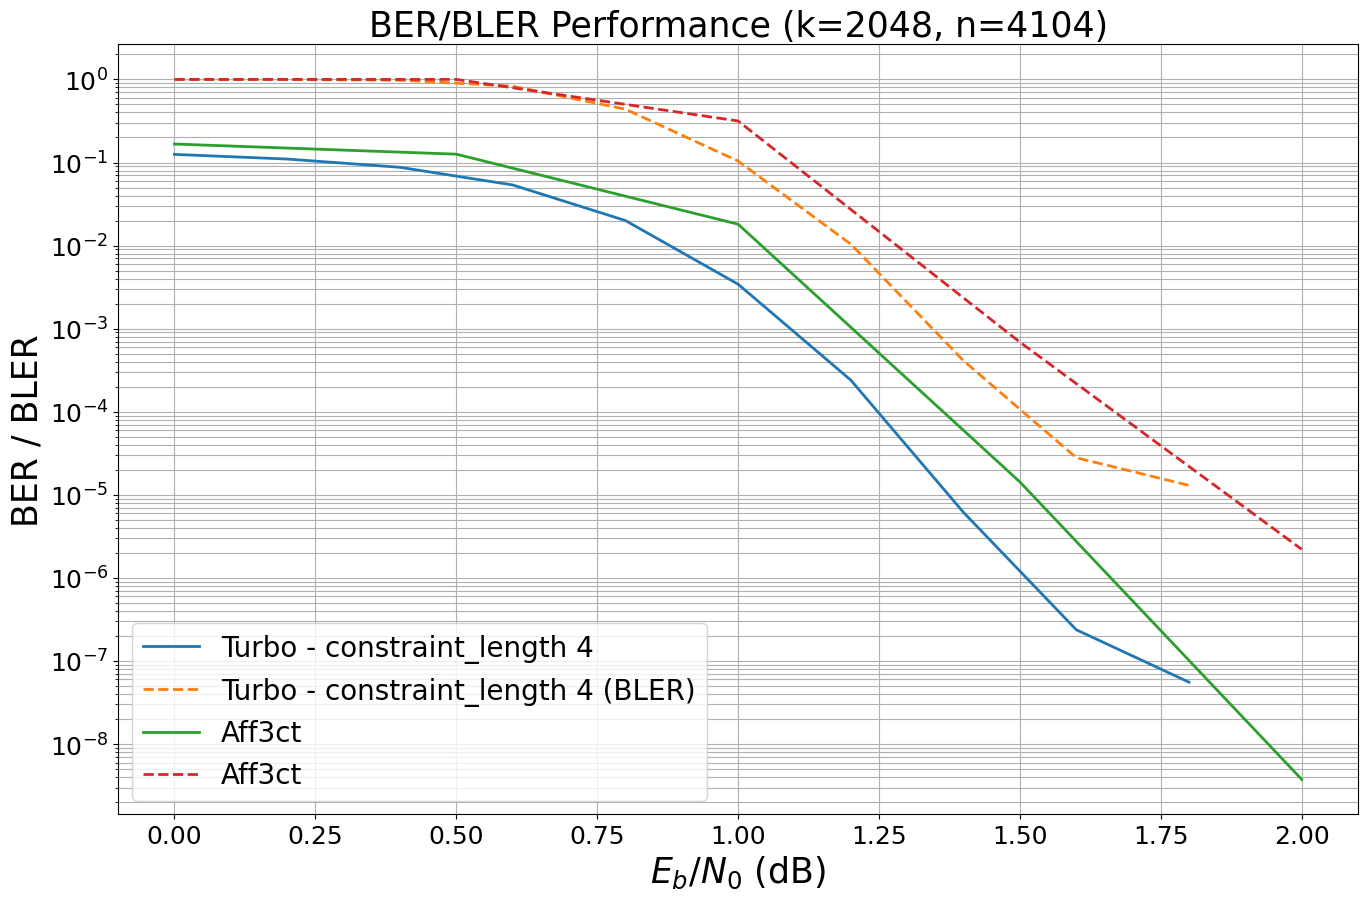

In [8]:
# and show the figure
ber_plot2()

### Aff3ct k=6144/n=18444

In [9]:
# code parameters
k = 6144 # number of information bits per codeword
n = 18444 # desired codeword length
num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(0, 1, 0.2) # sim SNR range

codes_under_test = []
#Turbo. codes
enc = TurboEncoder(rate=1/3, constraint_length=4, terminate=True)
dec = TurboDecoder(encoder=enc, num_iter=6)
name = "Turbo - constraint_length " + str(enc.constraint_length)
codes_under_test.append([enc, dec, name])

ber_plot3 = PlotBER(f"BER/BLER Performance (k={k}, n={n})")

# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\n Running: " + code[2])

    # generate a new model with the given encoder/decoder
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1],
                         sim_esno=False)

    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    ber_plot3.simulate(model, # the function have defined previously
                     ebno_dbs=ebno_db, # SNR to simulate
                     legend=code[2], # legend string for plotting
                     max_mc_iter=100, # run 100 Monte Carlo runs per SNR point
                     num_target_bit_errors=1000, # continue with next SNR point after 1000 bit errors
                     batch_size=10000, # batch-size per Monte Carlo run
                     soft_estimates=False, # the model returns hard-estimates
                     early_stop=True, # stop simulation if no error has been detected at current SNR point
                     show_fig=False, # we show the figure after all results are simulated
                     add_bler=True, # in case BLER is also interresting
                     forward_keyboard_interrupt=False); # should be True in a loop

#Aff3ct results
#https://aff3ct.github.io/comparator.html?curve0=773c4e0&curve1=a3ee4f2&xaxis=Eb%2FN0&yaxes=BER%2CFER&xrange=-0.026776519052523172,1.973223480947477&yrange=-9.17124842407813,0.1896539704466922

snr = [0, 0.5, 1]
ber = [1.37e-01, 1.31e-03, 1.30e-08]
bler = [1., 2.21e-01, 3.26e-05]

ber_plot3.add(snr, ber, is_bler=False,legend="Aff3ct")
ber_plot3.add(snr, bler, is_bler=True,legend="Aff3ct")



 Running: Turbo - constraint_length 4
<dtype: 'float32'>


2024-11-27 11:34:01.391044: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_less_equal/Assert/Assert
2024-11-27 11:34:01.391138: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator assert_greater_equal/Assert/Assert


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 6.5806e-02 | 9.9830e-01 |     4043091 |    61440000 |         9983 |       10000 |        70.8 |reached target bit errors
      0.2 | 1.5874e-02 | 8.0190e-01 |      975278 |    61440000 |         8019 |       10000 |         4.9 |reached target bit errors
      0.4 | 6.3201e-04 | 1.5030e-01 |       38831 |    61440000 |         1503 |       10000 |         4.9 |reached target bit errors
      0.6 | 2.9948e-06 | 2.6667e-03 |        1104 |   368640000 |          160 |       60000 |        29.7 |reached target bit errors
      0.8 | 2.3926e-08 | 5.3000e-05 |         147 |  6144000000 |           53 |     1000000 |       495.1 |reached max iterations


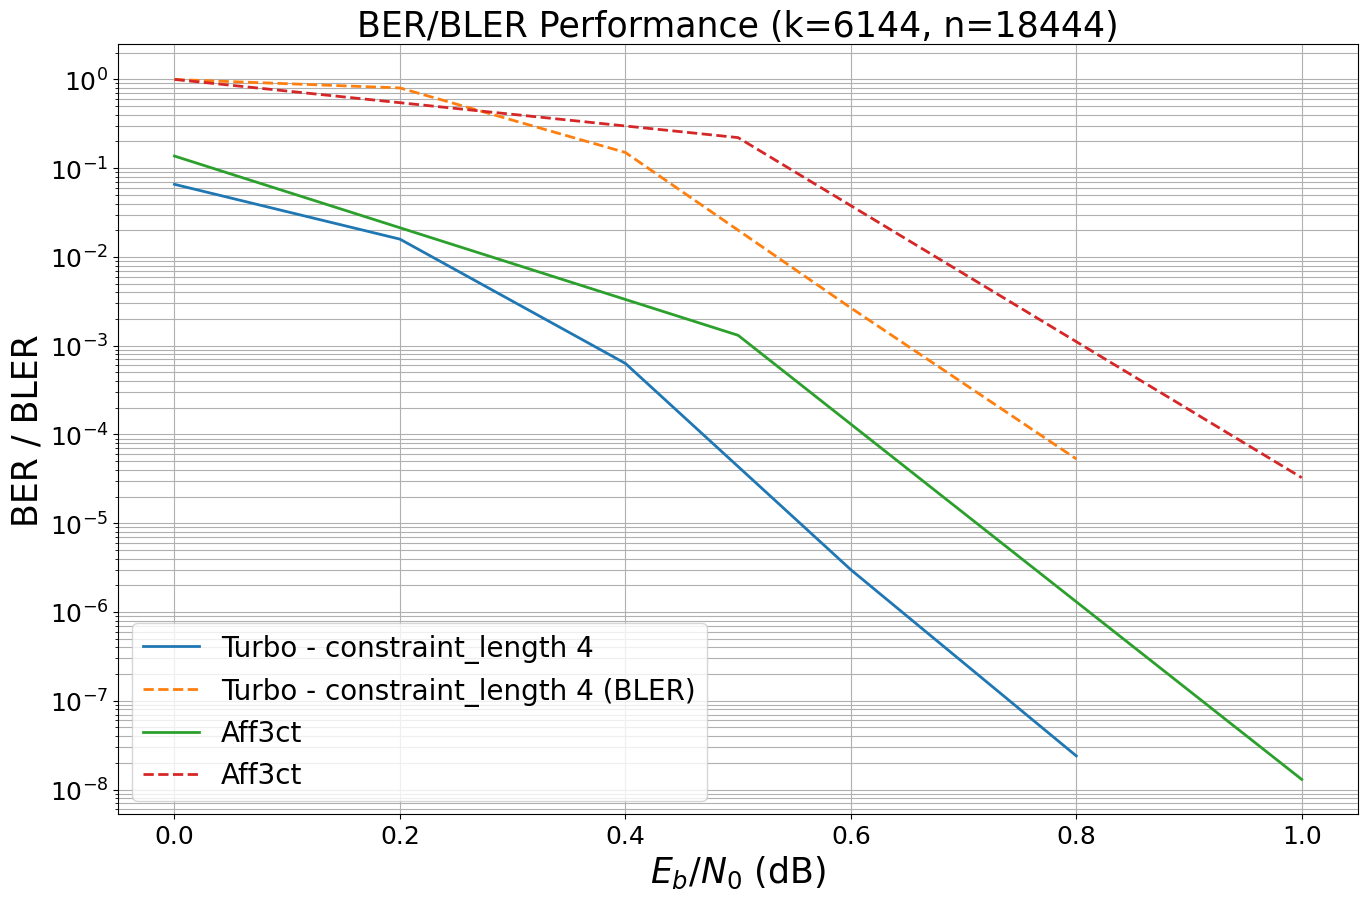

In [10]:
# and show the figure
ber_plot3()

## Test Polynomials & Constraint Length

Basic idea: the BLER performance should improve monotonically with increasing constraint length

### Convolutional code rate=1/2

In [11]:
# code parameters
k = 500 # number of information bits per codeword
n = 1000 # desired codeword length

num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(0, 8, 0.5) # sim SNR range

codes_under_test = []
# Conv. code with Viterbi decoding
for c in range(3,9):
    enc = ConvEncoder(rate=1/2, constraint_length=c)
    dec = ViterbiDecoder(gen_poly=enc.gen_poly)
    name = f"Conv. Code Viterbi (constraint length {c})"
    codes_under_test.append([enc, dec, name])

ber_plot4 = PlotBER(f"BER/BLER Performance (k={k}, n={n})")

# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\n Running: " + code[2])

    # generate a new model with the given encoder/decoder
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1],
                         sim_esno=False)

    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    ber_plot4.simulate(model, # the function have defined previously
                     ebno_dbs=ebno_db, # SNR to simulate
                     legend=code[2], # legend string for plotting
                     max_mc_iter=100, # run 100 Monte Carlo runs per SNR point
                     num_target_bit_errors=1000, # continue with next SNR point after 1000 bit errors
                     batch_size=10000, # batch-size per Monte Carlo run
                     soft_estimates=False, # the model returns hard-estimates
                     early_stop=True, # stop simulation if no error has been detected at current SNR point
                     show_fig=False, # we show the figure after all results are simulated
                     add_bler=True, # in case BLER is also interresting
                     forward_keyboard_interrupt=False); # should be True in a loop




 Running: Conv. Code Viterbi (constraint length 3)
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 9.2818e-02 | 1.0000e+00 |      464091 |     5000000 |        10000 |       10000 |         2.3 |reached target bit errors
      0.5 | 6.4701e-02 | 1.0000e+00 |      323506 |     5000000 |        10000 |       10000 |         0.0 |reached target bit errors
      1.0 | 4.2164e-02 | 9.9850e-01 |      210819 |     5000000 |         9985 |       10000 |         0.0 |reached target bit errors
      1.5 | 2.5978e-02 | 9.8790e-01 |      129892 |     5000000 |         9879 |       10000 |         0.0 |reached target bit errors
      2.0 | 1.4776e-02 | 9.2880e-01 |       73879 |     5000000 |         9288 |       10000 |         0.0 |reached target bit errors
      2.5 | 7.7686e-03 

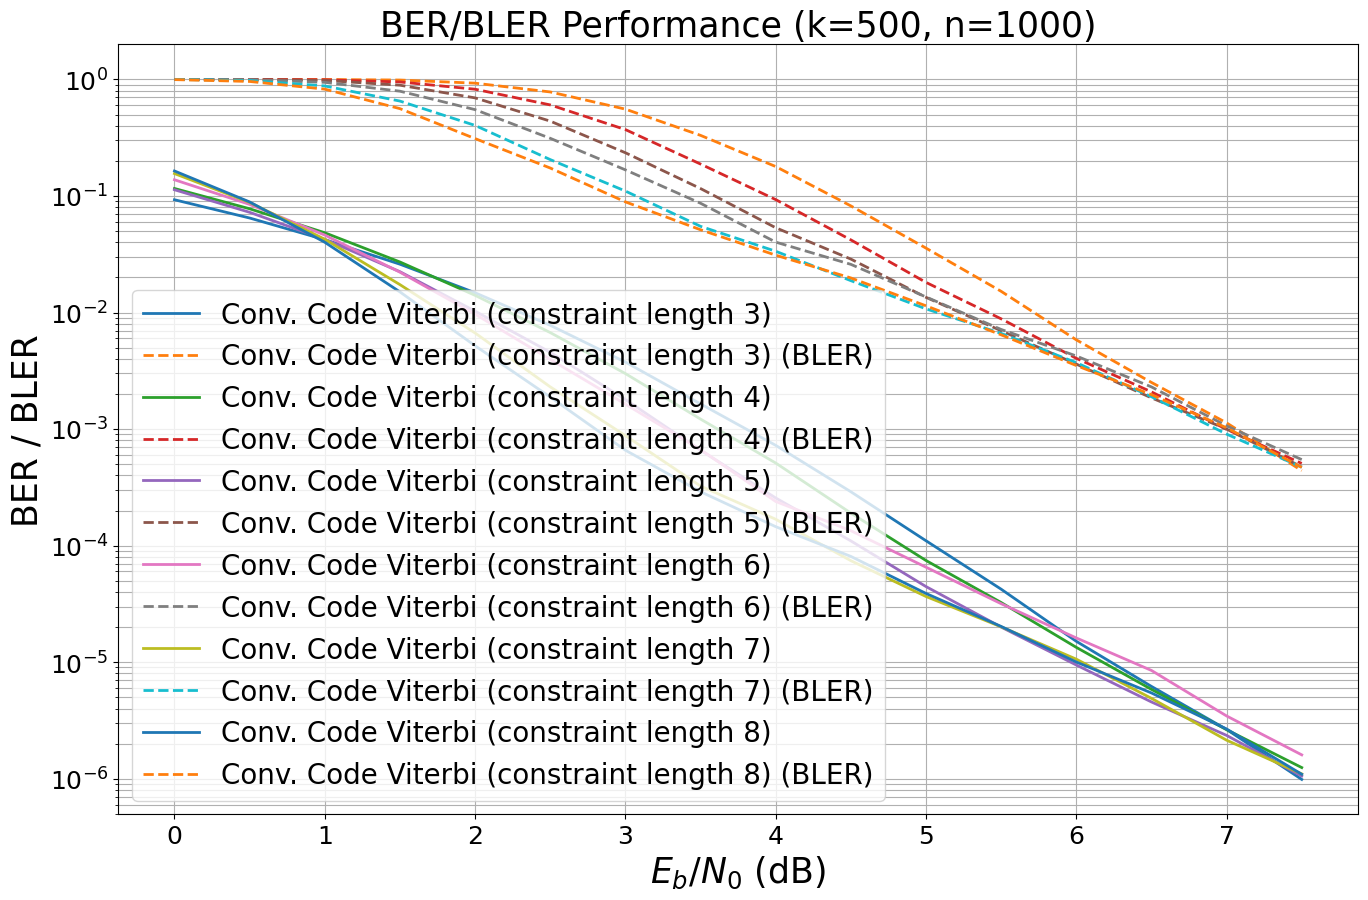

In [12]:
# and show the figure
ber_plot4()

### Convolutional code rate=1/3

In [13]:
# code parameters
k = 500 # number of information bits per codeword
n = 1500 # desired codeword length
num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(0, 8, 0.5) # sim SNR range

codes_under_test = []
# Conv. code with Viterbi decoding
for c in range(3,9):
    enc = ConvEncoder(rate=1/3, constraint_length=c)
    dec = ViterbiDecoder(gen_poly=enc.gen_poly)
    name = f"Conv. Code Viterbi (constraint length {c})"
    codes_under_test.append([enc, dec, name])

ber_plot5 = PlotBER(f"BER/BLER Performance (k={k}, n={n})")

# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\n Running: " + code[2])

    # generate a new model with the given encoder/decoder
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1],
                         sim_esno=False)

    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    ber_plot5.simulate(model, # the function have defined previously
                     ebno_dbs=ebno_db, # SNR to simulate
                     legend=code[2], # legend string for plotting
                     max_mc_iter=100, # run 100 Monte Carlo runs per SNR point
                     num_target_bit_errors=1000, # continue with next SNR point after 1000 bit errors
                     batch_size=10000, # batch-size per Monte Carlo run
                     soft_estimates=False, # the model returns hard-estimates
                     early_stop=True, # stop simulation if no error has been detected at current SNR point
                     show_fig=False, # we show the figure after all results are simulated
                     add_bler=True, # in case BLER is also interresting
                     forward_keyboard_interrupt=False); # should be True in a loop


 Running: Conv. Code Viterbi (constraint length 3)
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.0819e-01 | 1.0000e+00 |      540963 |     5000000 |        10000 |       10000 |         2.0 |reached target bit errors
      0.5 | 7.6740e-02 | 1.0000e+00 |      383699 |     5000000 |        10000 |       10000 |         0.1 |reached target bit errors
      1.0 | 5.0783e-02 | 9.9840e-01 |      253913 |     5000000 |         9984 |       10000 |         0.1 |reached target bit errors
      1.5 | 3.1682e-02 | 9.8990e-01 |      158412 |     5000000 |         9899 |       10000 |         0.1 |reached target bit errors
      2.0 | 1.8218e-02 | 9.3970e-01 |       91089 |     5000000 |         9397 |       10000 |         0.1 |reached target bit errors
      2.5 | 9.5758e-03 

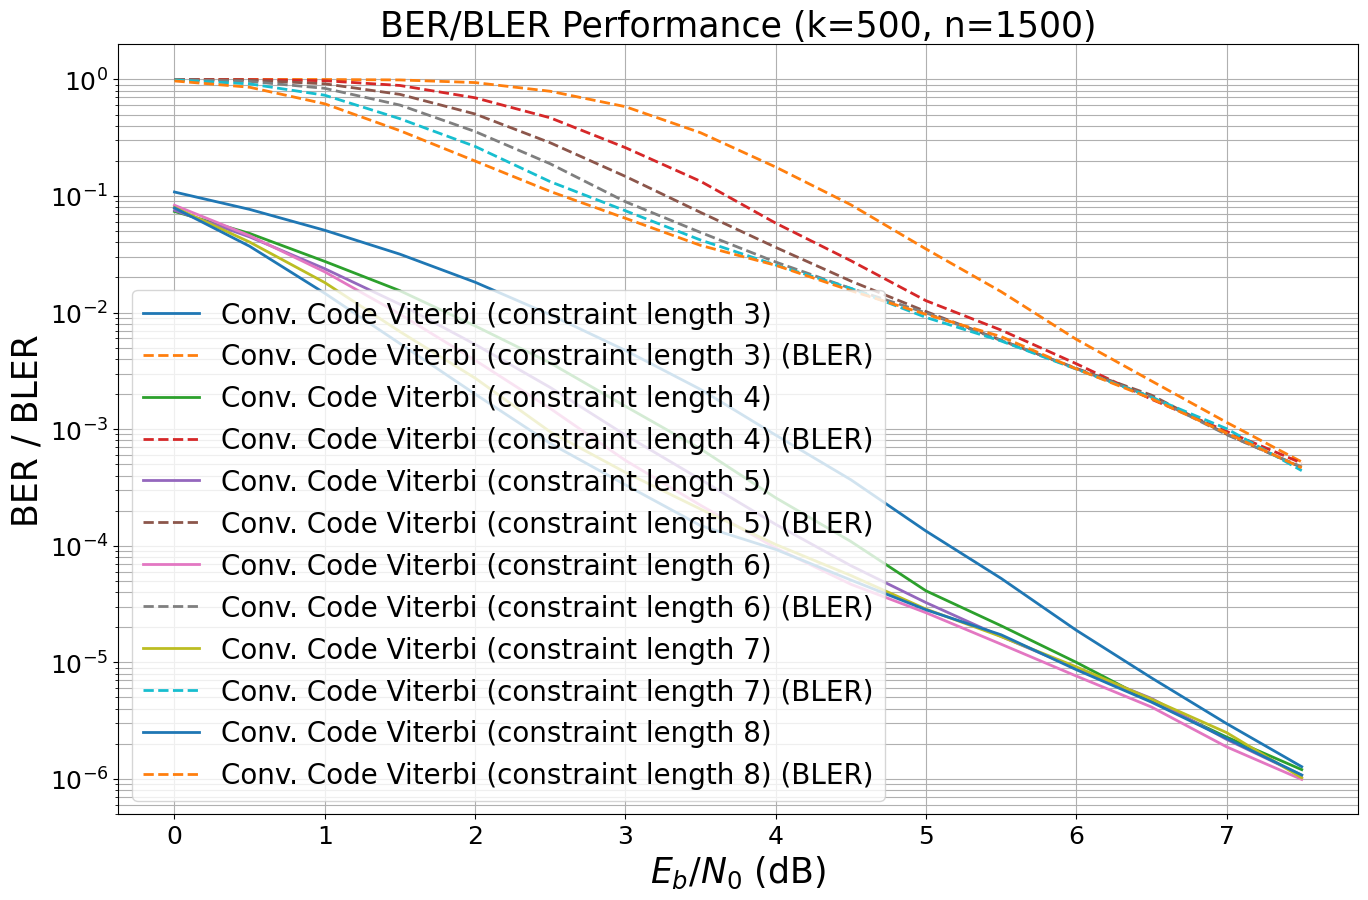

In [14]:
# and show the figure
ber_plot5()

### Turbo code rate=1/2

In [15]:
# code parameters
k = 500 # number of information bits per codeword
n = 1000 # desired codeword length
num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(0, 8, 0.5) # sim SNR range

codes_under_test = []
# Turbo Codes
for c in range(3,7):
    enc = TurboEncoder(rate=1/2, constraint_length=c, terminate=False)
    dec = TurboDecoder(encoder=enc, num_iter=6)
    name = "Turbo - constraint_length " + str(enc.constraint_length)
    codes_under_test.append([enc, dec, name])

ber_plot6 = PlotBER(f"BER/BLER Performance (k={k}, n={n})")

# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\n Running: " + code[2])

    # generate a new model with the given encoder/decoder
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1],
                         sim_esno=False)

    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    ber_plot6.simulate(model, # the function have defined previously
                     ebno_dbs=ebno_db, # SNR to simulate
                     legend=code[2], # legend string for plotting
                     max_mc_iter=100, # run 100 Monte Carlo runs per SNR point
                     num_target_bit_errors=1000, # continue with next SNR point after 1000 bit errors
                     batch_size=10000, # batch-size per Monte Carlo run
                     soft_estimates=False, # the model returns hard-estimates
                     early_stop=True, # stop simulation if no error has been detected at current SNR point
                     show_fig=False, # we show the figure after all results are simulated
                     add_bler=True, # in case BLER is also interresting
                     forward_keyboard_interrupt=False); # should be True in a loop





 Running: Turbo - constraint_length 3
<dtype: 'float32'>
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.0699e-01 | 9.9500e-01 |      534947 |     5000000 |         9950 |       10000 |        24.6 |reached target bit errors
      0.5 | 6.1869e-02 | 8.8270e-01 |      309347 |     5000000 |         8827 |       10000 |         0.3 |reached target bit errors
      1.0 | 1.8446e-02 | 4.5440e-01 |       92230 |     5000000 |         4544 |       10000 |         0.3 |reached target bit errors
      1.5 | 2.4230e-03 | 1.0300e-01 |       12115 |     5000000 |         1030 |       10000 |         0.3 |reached target bit errors
      2.0 | 2.0260e-04 | 1.7200e-02 |        1013 |     5000000 |          172 |       10000 |         0.3 |reached target bit errors
      2.5 | 3.334

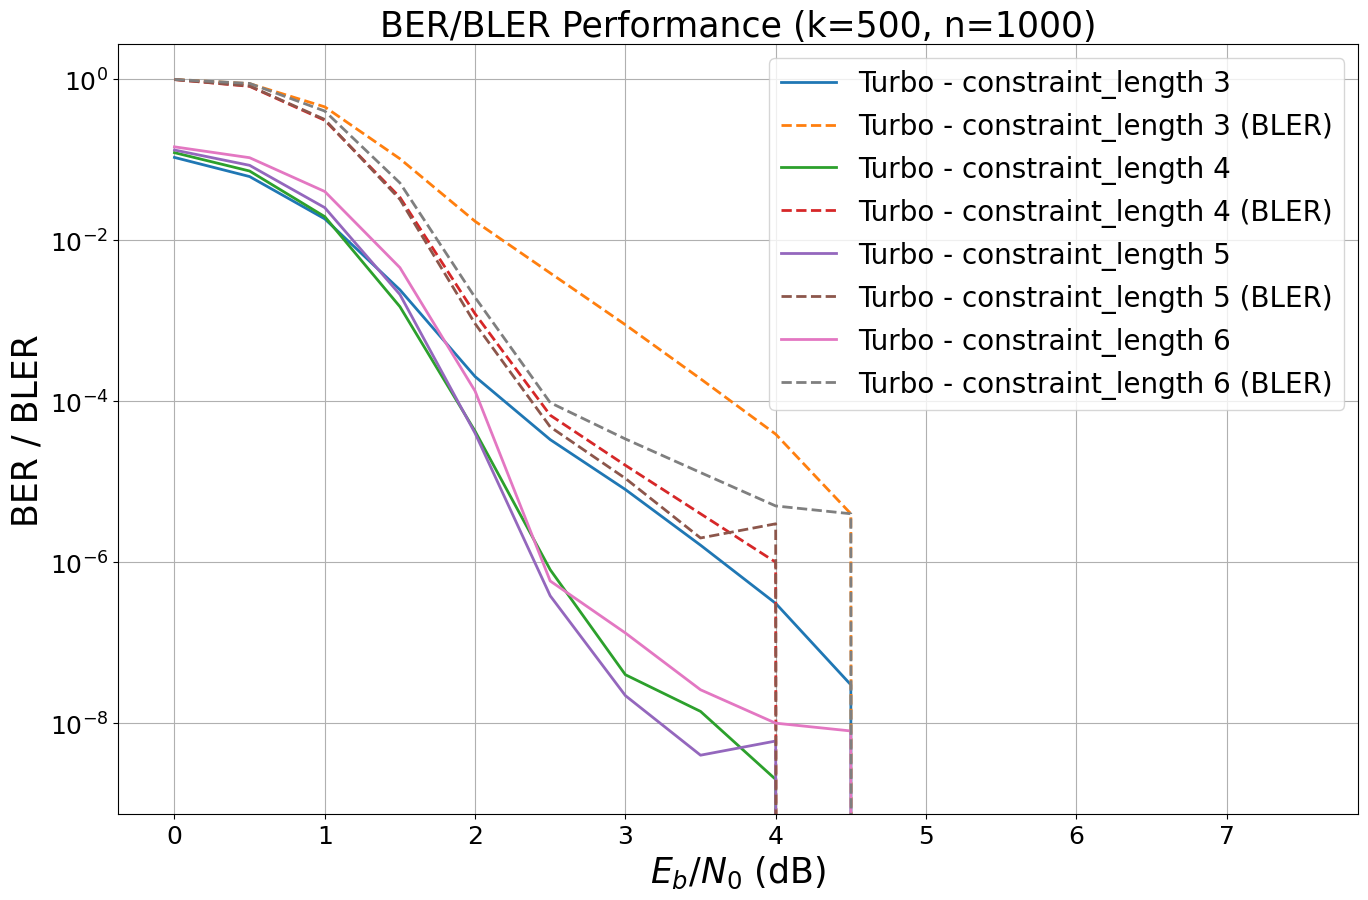

In [16]:
# and show the figure
ber_plot6()

### Turbo code rate=1/3

In [17]:
# code parameters
k = 500 # number of information bits per codeword
n = 1500 # desired codeword length
num_bits_per_symbol = 2 # QPSK
ebno_db = np.arange(0, 8, 0.5) # sim SNR range

codes_under_test = []
# Turbo Codes
for c in range(3,7):
    enc = TurboEncoder(rate=1/3, constraint_length=c, terminate=False)
    dec = TurboDecoder(encoder=enc, num_iter=6)
    name = "Turbo - constraint_length " + str(enc.constraint_length)
    codes_under_test.append([enc, dec, name])

ber_plot7 = PlotBER(f"BER/BLER Performance (k={k}, n={n})")

# run ber simulations for each code we have added to the list
for code in codes_under_test:
    print("\n Running: " + code[2])

    # generate a new model with the given encoder/decoder
    model = System_Model(k=k,
                         n=n,
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1],
                         sim_esno=False)

    # the first argument must be a callable (function) that yields u and u_hat for batch_size and ebno
    ber_plot7.simulate(model, # the function have defined previously
                     ebno_dbs=ebno_db, # SNR to simulate
                     legend=code[2], # legend string for plotting
                     max_mc_iter=100, # run 100 Monte Carlo runs per SNR point
                     num_target_bit_errors=1000, # continue with next SNR point after 1000 bit errors
                     batch_size=10000, # batch-size per Monte Carlo run
                     soft_estimates=False, # the model returns hard-estimates
                     early_stop=True, # stop simulation if no error has been detected at current SNR point
                     show_fig=False, # we show the figure after all results are simulated
                     add_bler=True, # in case BLER is also interresting
                     forward_keyboard_interrupt=False); # should be True in a loop





 Running: Turbo - constraint_length 3
<dtype: 'float32'>
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 6.5034e-02 | 8.4120e-01 |      325168 |     5000000 |         8412 |       10000 |        25.1 |reached target bit errors
      0.5 | 1.5456e-02 | 3.8080e-01 |       77281 |     5000000 |         3808 |       10000 |         0.3 |reached target bit errors
      1.0 | 1.3980e-03 | 7.5200e-02 |        6990 |     5000000 |          752 |       10000 |         0.3 |reached target bit errors
      1.5 | 1.6750e-04 | 1.6100e-02 |        1675 |    10000000 |          322 |       20000 |         0.7 |reached target bit errors
      2.0 | 3.2057e-05 | 3.5429e-03 |        1122 |    35000000 |          248 |       70000 |         2.4 |reached target bit errors
      2.5 | 1.018

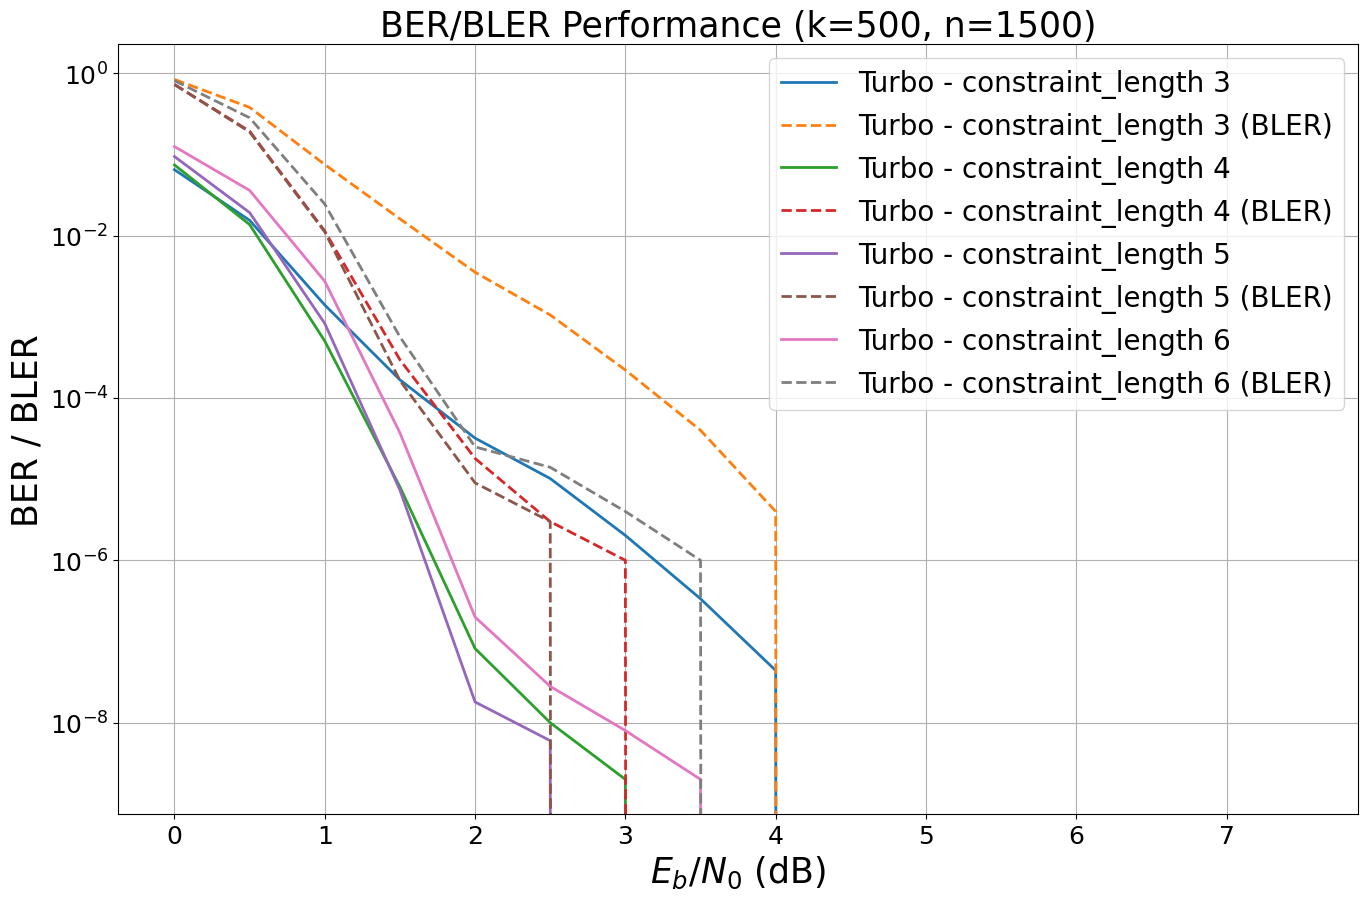

In [18]:
# and show the figure
ber_plot7()